In [1]:
import os
import utils
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
import statsmodels.formula.api as smf
from glob import glob
from datetime import datetime
import tensorflow as tf
import keras
from keras import Input, layers
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, LeakyReLU, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.utils import np_utils
import random
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.linear_model import LinearRegression
from fireTS.models import NARX
seed_value = 2022
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
from sklearn.preprocessing import QuantileTransformer 
normalizer = QuantileTransformer(output_distribution='normal')

In [2]:
def baSpread(x):
    a=x['AP1'].values.tolist()
    b=x['BP1'].values.tolist()
    bas=np.empty(len(x))
    for i in range(len(a)):
       bas[i]=(a[i]/10**4-b[i]/10**4)#/(a[i]+b[i])*10**4
    return bas

In [3]:
lob_data=utils.caricaLOB('bynd',0.05)
ld=lob_data.values.tolist()
of=utils.OF_1(ld)
bCols=np.ravel([['aOF_%d'%level, 'bOF_%d'%level] for level in [1,2,3]])
of_data=pd.DataFrame(of, columns=bCols)
m=pd.DataFrame(utils.midPrice(lob_data),columns=['m'])
m['r']=m['m'].pct_change().fillna(0).copy()
b=pd.DataFrame(baSpread(lob_data),columns=['spread'])
b['d']=b['spread'].diff().dropna()
spread=b['d'].fillna(0).to_numpy()
np.quantile(spread,0.9), np.quantile(spread,0.1)

(0.020000000000010232, -0.030000000000001137)

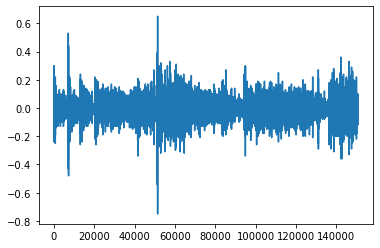

In [4]:
hot=np.zeros(len(spread))
for i in range(0,len(hot)):
    if spread[i]>0.02: 
        hot[i]=1 
    elif spread[i]<-0.03:
        hot[i]=2 
    else:
        hot[i]=0
plt.plot(spread);

In [5]:
np.quantile(spread,0.9), np.quantile(spread,0.1), stats.mode(b)

(0.020000000000010232,
 -0.030000000000001137,
 ModeResult(mode=array([[0.05, 0.  ]]), count=array([[13518, 83285]])))

In [6]:
hot,spread

(array([0., 0., 1., ..., 0., 2., 1.]),
 array([ 0.  ,  0.  ,  0.05, ...,  0.  , -0.04,  0.04]))

CNN-LSTM Classifier
===

In [7]:
def prepare_x_y(of, lag=100, dimension=6):
    ex = of[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']].to_numpy()#
    uai= of['h'].to_numpy() #.pct_change().fillna(0)['r']
    shape = of.shape
    dimension=6
    lag = 100
    x=np.empty((shape[0]-lag, lag, dimension))
    y=np.empty((shape[0]-lag,1))
    for i in range(shape[0]-lag):
        x[i]=ex[i:i+lag]
        y[i]=uai[i+lag-1]

    X=x.reshape(-1,lag,6,1)

    Y = np_utils.to_categorical(y.astype(int),3)

    return X,Y

In [8]:
V = int(len(of)*0.6)
T = int(len(of)*0.8)

n_train     = of_data.iloc[ :V].copy()
n_vali      = of_data.iloc[V:T].copy()
n_test      = of_data.iloc[T: ].copy()

n_train = n_train.apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_vali  = n_vali .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_test  = n_test .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)

x_vars = of_data.columns#[:-1]

# Normalize Features
# Dividing by the standard deviation estimated using the training set
for x_var in x_vars:
    sd = n_train[x_var].std()
    n_train[x_var] = n_train[x_var] / sd
    n_vali [x_var] = n_vali [x_var] / sd
    n_test [x_var] = n_test [x_var] / sd

n_train['h'] = hot[ :V]
n_vali ['h'] = hot[V:T]
n_test ['h'] = hot[T: ]
#of=of_data

trainX,trainY = prepare_x_y  (n_train)    
valiX ,valiY  = prepare_x_y  (n_vali )    
testX ,testY  = prepare_x_y  (n_test )   


print(trainX.shape ,trainY.shape)
print(valiX.shape  ,valiY .shape)
print(testX.shape  ,testY .shape)

(90368, 100, 6, 1) (90368, 3)
(30056, 100, 6, 1) (30056, 3)
(30056, 100, 6, 1) (30056, 3)


In [9]:

def create_nn(T, NF,number_of_lstm):

    input_lmd = tf.keras.Input(shape=(T, NF, 1))

    conv_first1 = Conv2D(32, kernel_size=(1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    #
    layer_x = layers.Conv2D(filters=16, kernel_size=(10,1),strides=(1,10), padding='same')(conv_first1)
    layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
    # inception
    convsecond_1 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same', strides=(1,1))(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same', strides=(1,1))(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(layer_x)
    convsecond_3 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.7, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)

    # build the output layer
    out = Dense(3, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])#

    return model
checkpoint_filepath = './model_tensorflow2/weights_class'
deeplob = create_nn(100, 6, 64)
deeplob.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 6, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 100, 3, 32)   96          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 100, 3, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 3, 32)   4128        ['leaky_re_lu[0][0]']            
                                                                                              

In [10]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)
saving = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [11]:
#deeplob.load_weights('modelMSFTClassification.h5')
simple=deeplob.fit(trainX, trainY, validation_data=(valiX, valiY),  epochs=50, batch_size=256,callbacks=[callback,saving])

Epoch 1/50
353/353 [==============================] - 259s 709ms/step - loss: 0.7148 - accuracy: 0.7779 - val_loss: 0.6256 - val_accuracy: 0.7969
Epoch 2/50
353/353 [==============================] - 252s 715ms/step - loss: 0.6312 - accuracy: 0.7829 - val_loss: 0.5861 - val_accuracy: 0.7969
Epoch 3/50
353/353 [==============================] - 252s 713ms/step - loss: 0.6027 - accuracy: 0.7834 - val_loss: 0.5578 - val_accuracy: 0.7978
Epoch 4/50
353/353 [==============================] - 254s 719ms/step - loss: 0.5655 - accuracy: 0.7837 - val_loss: 0.5139 - val_accuracy: 0.7994
Epoch 5/50
353/353 [==============================] - 263s 745ms/step - loss: 0.5294 - accuracy: 0.7846 - val_loss: 0.4971 - val_accuracy: 0.7997
Epoch 6/50
353/353 [==============================] - 253s 717ms/step - loss: 0.5127 - accuracy: 0.7861 - val_loss: 0.4797 - val_accuracy: 0.8041
Epoch 7/50
353/353 [==============================] - 258s 730ms/step - loss: 0.5049 - accuracy: 0.7870 - val_loss: 0.4787 -

In [12]:
deeplob.save('modelBYNDdiff7Classification.h5')


In [13]:
P = deeplob.predict(testX)
pj= np.round(P)
P

940/940 [==============================] - 23s 22ms/step


array([[9.9406058e-01, 5.9303381e-03, 9.0407875e-06],
       [8.4945363e-01, 1.5037994e-01, 1.6635428e-04],
       [7.6904488e-01, 1.2935682e-02, 2.1801943e-01],
       ...,
       [9.4226784e-01, 5.6130566e-02, 1.6017185e-03],
       [9.9620432e-01, 3.6153854e-03, 1.8028128e-04],
       [4.2845055e-01, 2.4507579e-03, 5.6909871e-01]], dtype=float32)

In [14]:
from sklearn.metrics import classification_report, accuracy_score
print('accuracy_score:', accuracy_score(np.argmax(testY, axis=1), np.argmax(pj, axis=1)))
print(classification_report(np.argmax(testY, axis=1), np.argmax(pj, axis=1), digits=4))

accuracy_score: 0.8240617513973916
              precision    recall  f1-score   support

           0     0.8589    0.9354    0.8955     24143
           1     0.5741    0.3089    0.4017      3059
           2     0.5858    0.4341    0.4987      2854

    accuracy                         0.8241     30056
   macro avg     0.6729    0.5595    0.5986     30056
weighted avg     0.8040    0.8241    0.8076     30056



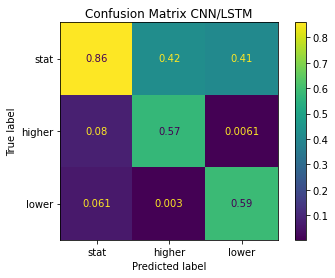

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(testY.argmax(axis=1), pj.argmax(axis=1),normalize='pred')#true', 'pred', 'all'
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['stat','higher','lower'])
disp.plot()
disp.ax_.set_title("Confusion Matrix CNN/LSTM");

LSTM classifier
===

In [16]:
def prepare_x_y_lstm(of, lag=100, dimension=6):
    ex = of[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']].to_numpy()#
    uai= of['h'].to_numpy() #.pct_change().fillna(0)['r']
    shape = of.shape
    dimension=6
    lag = 100
    x=np.empty((shape[0]-lag, lag, dimension))
    y=np.empty((shape[0]-lag,1))
    for i in range(shape[0]-lag):
        x[i]=ex[i:i+lag]
        y[i]=uai[i+lag-1]

    X=x.reshape(-1,lag,6)

    Y = np_utils.to_categorical(y.astype(int),3)

    return X,Y

In [17]:
V = int(len(of)*0.6)
T = int(len(of)*0.8)

n_train     = of_data.iloc[ :V].copy()
n_vali      = of_data.iloc[V:T].copy()
n_test      = of_data.iloc[T: ].copy()

n_train = n_train.apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_vali  = n_vali .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_test  = n_test .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)

x_vars = of_data.columns#[:-1]

# Normalize Features
# Dividing by the standard deviation estimated using the training set
for x_var in x_vars:
    sd = n_train[x_var].std()
    n_train[x_var] = n_train[x_var] / sd
    n_vali [x_var] = n_vali [x_var] / sd
    n_test [x_var] = n_test [x_var] / sd

n_train['h'] = hot[ :V]
n_vali ['h'] = hot[V:T]
n_test ['h'] = hot[T: ]
#of=of_data

trainX_lstm,trainY_lstm = prepare_x_y_lstm  (n_train)    
valiX_lstm,valiY_lstm = prepare_x_y_lstm  (n_vali )    
testX_lstm,testY_lstm = prepare_x_y_lstm  (n_test )   


print(trainX_lstm.shape ,trainY_lstm .shape)
print(valiX_lstm.shape  ,valiY_lstm .shape)
print(testX_lstm.shape  ,testY_lstm .shape)

(90368, 100, 6) (90368, 3)
(30056, 100, 6) (30056, 3)
(30056, 100, 6) (30056, 3)


In [18]:
#architettura della rete
num_units = 64
activation_function = 'leaky_relu'
adam = keras.optimizers.Adam(learning_rate=0.001)
loss_function = 'categorical_crossentropy'
batch_size = 250
num_epochs = 50
i = Input(shape=(100, 6))
x = LSTM(64, return_sequences=True)(i)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = LSTM(64, return_sequences=True)(x)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = LSTM(64, return_sequences=True)(x)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = keras.layers.Dropout(0.7)(x, training=True)
#x = LSTM(64, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(3, activation='softmax')(x)


model = Model(i, x)


callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

model.compile(optimizer = adam, loss = loss_function, metrics=['accuracy'])
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 6)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           18176     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 100, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 64)           33024     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 100, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100, 64)           33024     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 100, 64)           0   

In [19]:
#model.load_weights('classifyLSTM.h5')
lstmMSFT=model.fit(trainX_lstm, trainY_lstm, validation_data=(valiX_lstm, valiY_lstm), epochs=20, batch_size=256)

Epoch 1/20
353/353 [==============================] - 209s 579ms/step - loss: 0.6826 - accuracy: 0.7802 - val_loss: 0.6420 - val_accuracy: 0.7971
Epoch 2/20
353/353 [==============================] - 196s 556ms/step - loss: 0.6715 - accuracy: 0.7831 - val_loss: 0.6422 - val_accuracy: 0.7971
Epoch 3/20
353/353 [==============================] - 209s 594ms/step - loss: 0.6702 - accuracy: 0.7831 - val_loss: 0.6419 - val_accuracy: 0.7971
Epoch 4/20
353/353 [==============================] - 211s 597ms/step - loss: 0.6689 - accuracy: 0.7831 - val_loss: 0.6455 - val_accuracy: 0.7971
Epoch 5/20
353/353 [==============================] - 216s 611ms/step - loss: 0.6679 - accuracy: 0.7831 - val_loss: 0.6432 - val_accuracy: 0.7971
Epoch 6/20
353/353 [==============================] - 213s 605ms/step - loss: 0.6664 - accuracy: 0.7831 - val_loss: 0.6422 - val_accuracy: 0.7971
Epoch 7/20
353/353 [==============================] - 204s 578ms/step - loss: 0.6656 - accuracy: 0.7831 - val_loss: 0.6450 -

In [20]:
#model.save('lstmBYNDClassification.h5')

In [21]:
P_lstm = model.predict(testX_lstm)
p_lstmj= np.round(P_lstm)
P_lstm

940/940 [==============================] - 19s 20ms/step


array([[0.93224543, 0.04437555, 0.02337902],
       [0.8611348 , 0.06102256, 0.07784253],
       [0.836084  , 0.09949684, 0.0644192 ],
       ...,
       [0.95119953, 0.01644011, 0.03236036],
       [0.96356225, 0.02034897, 0.01608871],
       [0.8619734 , 0.09096915, 0.04705747]], dtype=float32)

In [22]:
from sklearn.metrics import classification_report, accuracy_score
print('accuracy_score:', accuracy_score(np.argmax(testY_lstm, axis=1), np.argmax(p_lstmj, axis=1)))
print(classification_report(np.argmax(testY_lstm, axis=1), np.argmax(p_lstmj, axis=1), digits=4))

accuracy_score: 0.8035999467660367
              precision    recall  f1-score   support

           0     0.8040    0.9993    0.8911     24143
           1     0.5000    0.0052    0.0104      3059
           2     0.6875    0.0039    0.0077      2854

    accuracy                         0.8036     30056
   macro avg     0.6638    0.3361    0.3030     30056
weighted avg     0.7620    0.8036    0.7175     30056



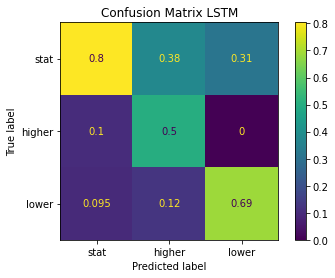

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(testY_lstm.argmax(axis=1), p_lstmj.argmax(axis=1),normalize='pred')#true', 'pred', 'all'
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['stat','higher','lower'])
disp.plot()
disp.ax_.set_title("Confusion Matrix LSTM");

Naive Gaussian Classifier
===

In [24]:
rng = np.random.RandomState(1)
X = n_train[['aOF_1'	,'bOF_1'	,'aOF_2'	,'bOF_2'	,'aOF_3',	'bOF_3']].to_numpy()
y = n_train['h'].to_numpy()
Xte = n_vali[['aOF_1'	,'bOF_1'	,'aOF_2'	,'bOF_2'	,'aOF_3',	'bOF_3']].to_numpy()
Yte = n_vali['h'].to_numpy()#['h'].to_numpy()
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
clf = GaussianNB()
clf.fit(X, y)
predNB = clf.predict(Xte)
encPr=np_utils.to_categorical(predNB)
#encTe=np_utils.to_categorical(Yte)
print(predNB,Yte)

[0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]


In [25]:
encTe=np_utils.to_categorical(n_vali['h'].to_numpy())

In [26]:
print('accuracy_score:', accuracy_score(np.argmax(encTe, axis=1), np.argmax(encPr, axis=1)))
print(classification_report(np.argmax(encTe, axis=1), np.argmax(encPr, axis=1), digits=4))

accuracy_score: 0.7842220453641067
              precision    recall  f1-score   support

           0     0.7980    0.9802    0.8798     24049
           1     0.1554    0.0095    0.0179      3166
           2     0.1064    0.0153    0.0268      2941

    accuracy                         0.7842     30156
   macro avg     0.3533    0.3350    0.3081     30156
weighted avg     0.6631    0.7842    0.7061     30156



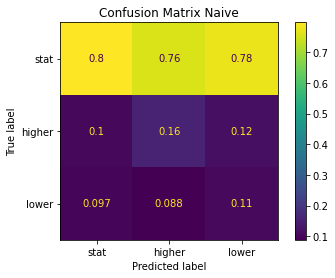

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(encTe.argmax(axis=1), encPr.argmax(axis=1),normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['stat','higher','lower'])
disp.plot()
disp.ax_.set_title("Confusion Matrix Naive");

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].set_title("CNN/LSTM")
ax[1].set_title("LSTM")
ax[2].set_title("Naive")

cm = confusion_matrix(testY.argmax(axis=1), pj.argmax(axis=1),normalize='pred')#true', 'pred', 'all'
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['stat','higher','lower'])
disp.plot(ax=ax[0])
disp.ax_.set_title("Confusion Matrix CNN/LSTM")
cm_lstm = confusion_matrix(testY_lstm.argmax(axis=1), p_lstmj.argmax(axis=1),normalize='pred')#true', 'pred', 'all'
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm,display_labels=['stat','higher','lower'])
disp_lstm.plot(ax=ax[1])
disp_lstm.ax_.set_title("Confusion Matrix LSTM")
cmNaiv = confusion_matrix(encTe.argmax(axis=1), encPr.argmax(axis=1),normalize='pred')
dispNaiv = ConfusionMatrixDisplay(confusion_matrix=cmNaiv,display_labels=['stat','higher','lower'])
dispNaiv.plot(ax=ax[2])
dispNaiv.ax_.set_title("Confusion Matrix Naive")
plt.tight_layout()  ;

In [ ]:
stop

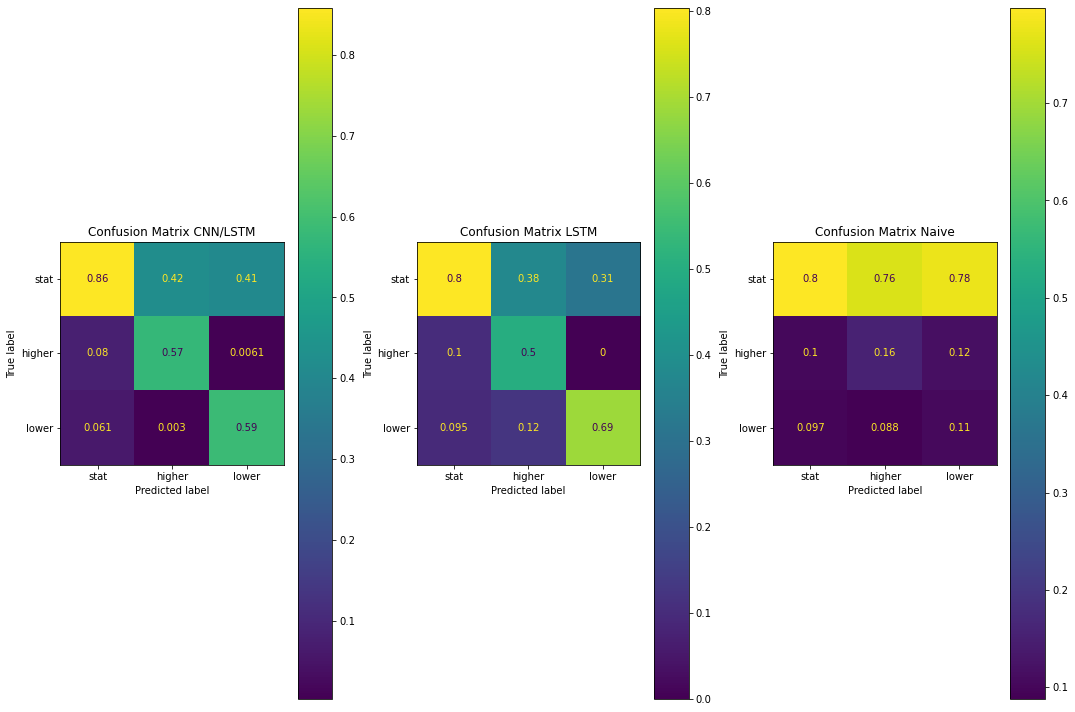

In [28]:
#a un passo
fig, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].set_title("CNN/LSTM")
ax[1].set_title("LSTM")
ax[2].set_title("Naive")

cm = confusion_matrix(testY.argmax(axis=1), pj.argmax(axis=1),normalize='pred')#true', 'pred', 'all'
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['stat','higher','lower'])
disp.plot(ax=ax[0])
disp.ax_.set_title("Confusion Matrix CNN/LSTM")
cm_lstm = confusion_matrix(testY_lstm.argmax(axis=1), p_lstmj.argmax(axis=1),normalize='pred')#true', 'pred', 'all'
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm,display_labels=['stat','higher','lower'])
disp_lstm.plot(ax=ax[1])
disp_lstm.ax_.set_title("Confusion Matrix LSTM")
cmNaiv = confusion_matrix(encTe.argmax(axis=1), encPr.argmax(axis=1),normalize='pred')
dispNaiv = ConfusionMatrixDisplay(confusion_matrix=cmNaiv,display_labels=['stat','higher','lower'])
dispNaiv.plot(ax=ax[2])
dispNaiv.ax_.set_title("Confusion Matrix Naive")
plt.tight_layout()  ;

In [29]:
stop

NameError: name 'stop' is not defined

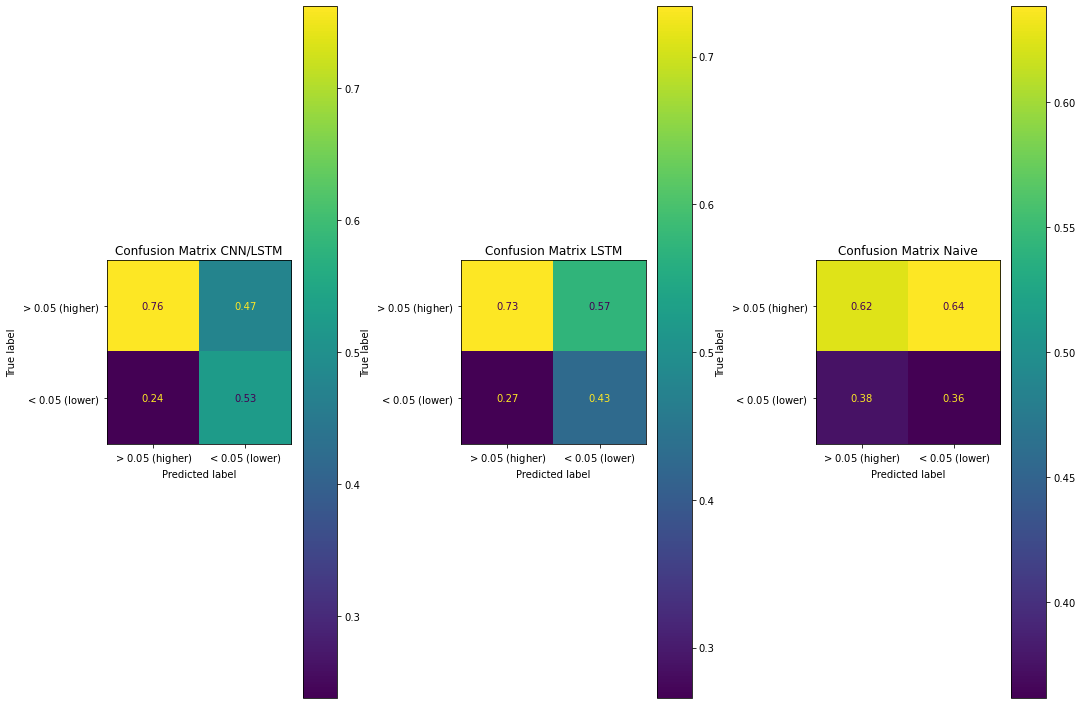

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].set_title("CNN/LSTM")
ax[1].set_title("LSTM")
ax[2].set_title("Naive")

cm = confusion_matrix(testY.argmax(axis=1), pj.argmax(axis=1),normalize='pred')#true', 'pred', 'all'
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['$>0.05$ (higher)','$<0.05$ (lower)'])
disp.plot(ax=ax[0])
disp.ax_.set_title("Confusion Matrix CNN/LSTM")
cm_lstm = confusion_matrix(testY_lstm.argmax(axis=1), p_lstmj.argmax(axis=1),normalize='pred')#true', 'pred', 'all'
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm,display_labels=['$>0.05$ (higher)','$<0.05$ (lower)'])
disp_lstm.plot(ax=ax[1])
disp_lstm.ax_.set_title("Confusion Matrix LSTM")
cmNaiv = confusion_matrix(encTe.argmax(axis=1), encPr.argmax(axis=1),normalize='pred')
dispNaiv = ConfusionMatrixDisplay(confusion_matrix=cmNaiv,display_labels=['$>0.05$ (higher)','$<0.05$ (lower)'])
dispNaiv.plot(ax=ax[2])
dispNaiv.ax_.set_title("Confusion Matrix Naive")
plt.tight_layout()  ;

1) Precision is a measure of how many of the positive predictions made are correct (true positives).
2) Accuracy describes the number of correct predictions over all predictions (TP+TN)/sizePop.
3) Recall is a measure of how many of the positive cases the classifier correctly predicted, over all the positive cases in the data.
4) F1 provides a single metric that weights the two ratios (precision and recall) in a balanced way.
    - Very small precision or recall will result in lower overall score. Thus it helps balance the two metrics.
    - If you choose your positive class as the one with fewer samples, F1-score can help balance the metric across positive/negative samples.